choose the model name. The model is already trained and saved by the training process.

In [ ]:
debugMode = False # False # True
num_epochs = 20

modelName = 'model'   #  'model_20epoch'   'model'-- 10 peochs


load the trained model

In [ ]:

model = LSTMForClassification(model_path=modelName)
model = model.to(device)
tokenizer = model.tokenizer

# model = LSTMForClassification().to(device)
# tokenizer = model.tokenizer
# model.train()
print(model)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.0001)


go directly to the testing part, and log the results

In [ ]:

loss_epoch = 0
acc_epoch = 0
with torch.no_grad():
    acc_test_epoch = 0
    hits = 0
    total = 0
    all_actual = None
    all_predicted = None
    for x, y in test_loader:
        test_out = model(x)
        _, prediction = torch.max(F.softmax(test_out, dim=1), 1)
        pred_y = prediction.data.cpu().numpy().squeeze()
        target_y = y.data.cpu().numpy()
        total += target_y.shape[0]
        hits += sum(pred_y == target_y)
        all_predicted = pred_y if all_predicted is None \
            else np.concatenate((all_predicted, pred_y))
        labels = target_y
        all_actual = labels if all_actual is None else np.concatenate((all_actual, labels))

        # acc_test_epoch +=  sum(pred_y == target_y)

    # accuracy = acc_test_epoch/NumTest
    accuracy = hits / total
    print('--  test accuracy', accuracy)
    prec_mac, recall_mac, f1_mac, _ = precision_recall_fscore_support(all_actual, all_predicted, average='macro')
    prec_mic, recall_mic, f1_mic, _ = precision_recall_fscore_support(all_actual, all_predicted, average='micro')
    print("Accuracy on the OOD test set 1: {:.4f}".format(accuracy))
    print("Precision on the OOD test set 1 macro / micro: {:.4f}, {:.4f}".format(prec_mac, prec_mic))
    print("Recall on the OOD test set 1 macro / micro: {:.4f}, {:.4f}".format(recall_mac, recall_mic))
    print("F1 on the OOD test set 1 macro / micro: {:.4f}, {:.4f}".format(f1_mac, f1_mic))
    print("Latex: {:5.2f} && {:5.2f} & {:5.2f} & {:5.2f}".format(f1_mic * 100, prec_mac * 100, recall_mac * 100,
                                                                f1_mac * 100))
    print("----------------------------------------------------------------------")



In [ ]:
--  test accuracy 0.9461426491994177
Accuracy on the OOD test set 1: 0.9461
Precision on the OOD test set 1 macro / micro: 0.9426, 0.9461
Recall on the OOD test set 1 macro / micro: 0.9478, 0.9461
F1 on the OOD test set 1 macro / micro: 0.9448, 0.9461
Latex: 94.61 && 94.26 & 94.78 & 94.48

to obtain the hidden layer embedding, for the visualization of the features

In [ ]:

with torch.no_grad():
    # model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in test_loader:

        # z_ = model.encoder(x.to(device))

        model.encoder.flatten_parameters()
        emb = model.emb_layer(x.to(device).t())
        emb = model.drop(emb)
        output, hidden = model.encoder(emb)
        output = torch.max(output, dim=0)[0]
        output = model.drop(output)
        z_ = output

        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

import matplotlib.pyplot as plt

transfer the embedding from 150 dimension to 2 dimension so we can plot in a 2D picture. We use SNE tool to do visualization.

In [ ]:

def scatter_plot(latent_representations, labels):
    # borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    def discrete_cmap(n, base_cmap=None):
        """Create an N-bin discrete colormap from the specified input map"""
        base = plt.cm.get_cmap(base_cmap)
        return base.from_list(base.name + str(n), base(np.linspace(0, 1, n)), n)

    plt.figure(figsize=(10, 10))
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1],  c=labels, cmap=discrete_cmap(2, 'jet')
                )   # , cmap=discrete_cmap(2, 'jet')   |  edgecolors='black'  cmap='viridis'  ,cmap='plasma',
    plt.colorbar()
    plt.grid()
    plt.show()

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
z_2d = tsne.fit_transform(z)

scatter_plot(latent_representations=z_2d,labels=label)


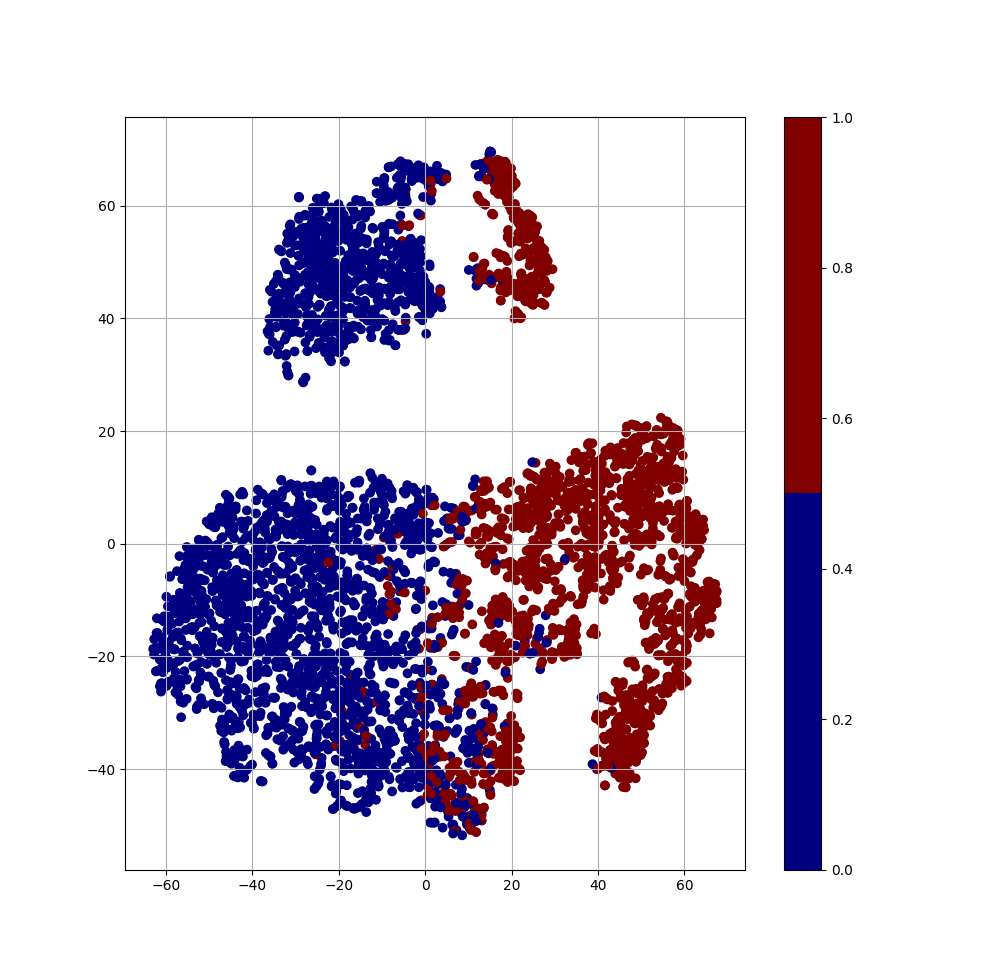